**Download the DataSet for lungseg**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp '/content/gdrive/My Drive/EECS545/dataset.tar.gz' '/content'


Mounted at /content/gdrive
Archive:  dataset.tar.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dataset.tar.gz or
        dataset.tar.gz.zip, and cannot find dataset.tar.gz.ZIP, period.


In [ ]:
!tar -xvf  'dataset.tar.gz' -C '/content'

dataset/
dataset/images/
dataset/images/CHNCXR_0001_0.png
dataset/images/CHNCXR_0002_0.png
dataset/images/CHNCXR_0003_0.png
dataset/images/CHNCXR_0004_0.png
dataset/images/CHNCXR_0005_0.png
dataset/images/CHNCXR_0006_0.png
dataset/images/CHNCXR_0007_0.png
dataset/images/CHNCXR_0008_0.png
dataset/images/CHNCXR_0009_0.png
dataset/images/CHNCXR_0010_0.png
dataset/images/CHNCXR_0011_0.png
dataset/images/CHNCXR_0012_0.png
dataset/images/CHNCXR_0013_0.png
dataset/images/CHNCXR_0014_0.png
dataset/images/CHNCXR_0015_0.png
dataset/images/CHNCXR_0016_0.png
dataset/images/CHNCXR_0017_0.png
dataset/images/CHNCXR_0018_0.png
dataset/images/CHNCXR_0019_0.png
dataset/images/CHNCXR_0020_0.png
dataset/images/CHNCXR_0021_0.png
dataset/images/CHNCXR_0022_0.png
dataset/images/CHNCXR_0023_0.png
dataset/images/CHNCXR_0024_0.png
dataset/images/CHNCXR_0025_0.png
dataset/images/CHNCXR_0026_0.png
dataset/images/CHNCXR_0027_0.png
dataset/images/CHNCXR_0028_0.png
dataset/images/CHNCXR_0029_0.png
dataset/images/CHN

**Data.py**

In [1]:
import torch
import torchvision

import pandas as pd
import numpy as np

from PIL import Image


class LungDataset(torch.utils.data.Dataset):
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms
    
    def __getitem__(self, idx):
        origin_name, mask_name = self.origin_mask_list[idx]
        origin = Image.open(self.origins_folder / (origin_name + ".png")).convert("P")
        mask = Image.open(self.masks_folder / (mask_name + ".png"))
        if self.transforms is not None:
            origin, mask = self.transforms((origin, mask))
            
        origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    
        mask = np.array(mask)
        mask = (torch.tensor(mask) > 128).long() 
        return origin, mask
        
    
    def __len__(self):
        return len(self.origin_mask_list)

    
class Pad():
    def __init__(self, max_padding):
        self.max_padding = max_padding
        
    def __call__(self, sample):
        origin, mask = sample
        padding = np.random.randint(0, self.max_padding)
#         origin = torchvision.transforms.functional.pad(origin, padding=padding, padding_mode="symmetric")
        origin = torchvision.transforms.functional.pad(origin, padding=padding, fill=0)
        mask = torchvision.transforms.functional.pad(mask, padding=padding, fill=0)
        return origin, mask


class Crop():
    def __init__(self, max_shift):
        self.max_shift = max_shift
        
    def __call__(self, sample):
        origin, mask = sample
        tl_shift = np.random.randint(0, self.max_shift)
        br_shift = np.random.randint(0, self.max_shift)
        origin_w, origin_h = origin.size
        crop_w = origin_w - tl_shift - br_shift
        crop_h = origin_h - tl_shift - br_shift
        
        origin = torchvision.transforms.functional.crop(origin, tl_shift, tl_shift,
                                                        crop_h, crop_w)
        mask = torchvision.transforms.functional.crop(mask, tl_shift, tl_shift,
                                                        crop_h, crop_w)
        return origin, mask


class Resize():
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, sample):
        origin, mask = sample
        origin = torchvision.transforms.functional.resize(origin, self.output_size)
        mask = torchvision.transforms.functional.resize(mask, self.output_size)
        
        return origin, mask


def blend(origin, mask1=None, mask2=None):
    img = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
    if mask1 is not None:
        mask1 =  torchvision.transforms.functional.to_pil_image(torch.cat([
            torch.zeros_like(origin),
            torch.stack([mask1.float()]),
            torch.zeros_like(origin)
        ]))
        img = Image.blend(img, mask1, 0.2)
        
    if mask2 is not None:
        mask2 =  torchvision.transforms.functional.to_pil_image(torch.cat([
            torch.stack([mask2.float()]),
            torch.zeros_like(origin),
            torch.zeros_like(origin)
        ]))
        img = Image.blend(img, mask2, 0.2)
    
    return img

**Model.py**

In [2]:
import torch
import torchvision

import pandas as pd
import numpy as np


class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, padding=1)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn1 = torch.nn.BatchNorm2d(mid_channel)
            self.bn2 = torch.nn.BatchNorm2d(out_channels)
            
    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        out = torch.nn.functional.relu(x, inplace=True)
        return out
    

class UNet(torch.nn.Module):
    def up(self, x, size):
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)
    
    def down(self, x):
        return torch.nn.functional.max_pool2d(x, kernel_size=2)
    
    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode
        
        self.enc1 = Block(in_channels, 64, 64, batch_norm)
        self.enc2 = Block(64, 128, 128, batch_norm)
        self.enc3 = Block(128, 256, 256, batch_norm)
        self.enc4 = Block(256, 512, 512, batch_norm)
        
        self.center = Block(512, 1024, 512, batch_norm)
        
        self.dec4 = Block(1024, 512, 256, batch_norm)
        self.dec3 = Block(512, 256, 128, batch_norm)
        self.dec2 = Block(256, 128, 64, batch_norm)
        self.dec1 = Block(128, 64, 64, batch_norm)
        
        self.out = torch.nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.down(enc1))
        enc3 = self.enc3(self.down(enc2))
        enc4 = self.enc4(self.down(enc3))
        
        center = self.center(self.down(enc4))
        
        dec4 = self.dec4(torch.cat([self.up(center, enc4.size()[-2:]), enc4], 1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))
        
        out = self.out(dec1)
        
        return out
    

class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)
    
    def down(self, x):
        return torch.nn.functional.max_pool2d(x, kernel_size=2)
    
    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode
        
        self.init_conv = torch.nn.Conv2d(in_channels, 3, 1)
        
        endcoder = torchvision.models.vgg11(pretrained=True).features
        self.conv1 = endcoder[0]   # 64
        self.conv2 = endcoder[3]   # 128
        self.conv3 = endcoder[6]   # 256
        self.conv3s = endcoder[8]  # 256
        self.conv4 = endcoder[11]   # 512
        self.conv4s = endcoder[13]  # 512
        self.conv5 = endcoder[16]  # 512
        self.conv5s = endcoder[18] # 512
    
        self.center = Block(512, 512, 256, batch_norm)
        
        self.dec5 = Block(512 + 256, 512, 256, batch_norm)
        self.dec4 = Block(512 + 256, 512, 128, batch_norm)
        self.dec3 = Block(256 + 128, 256, 64, batch_norm)
        self.dec2 = Block(128 + 64, 128, 32, batch_norm)
        self.dec1 = Block(64 + 32, 64, 32, batch_norm)
        
        self.out = torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1)

    def forward(self, x):  
        init_conv = torch.nn.functional.relu(self.init_conv(x), inplace=True)

        enc1 = torch.nn.functional.relu(self.conv1(init_conv), inplace=True)
        enc2 = torch.nn.functional.relu(self.conv2(self.down(enc1)), inplace=True)
        enc3 = torch.nn.functional.relu(self.conv3(self.down(enc2)), inplace=True)
        enc3 = torch.nn.functional.relu(self.conv3s(enc3), inplace=True)
        enc4 = torch.nn.functional.relu(self.conv4(self.down(enc3)), inplace=True)
        enc4 = torch.nn.functional.relu(self.conv4s(enc4), inplace=True)
        enc5 = torch.nn.functional.relu(self.conv5(self.down(enc4)), inplace=True)
        enc5 = torch.nn.functional.relu(self.conv5s(enc5), inplace=True)
        
        center = self.center(self.down(enc5))
        
        dec5 = self.dec5(torch.cat([self.up(center, enc5.size()[-2:]), enc5], 1))
        dec4 = self.dec4(torch.cat([self.up(dec5, enc4.size()[-2:]), enc4], 1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))
        
        out = self.out(dec1)
        
        return out

**Metric.py**

In [3]:
import torch
import torchvision

import pandas as pd
import numpy as np


def jaccard(y_true, y_pred):
    """ Jaccard a.k.a IoU score for batch of images
    """
    
    num = y_true.size(0)
    eps = 1e-7
    
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)
    intersection = (y_true_flat * y_pred_flat).sum(1)
    union = ((y_true_flat + y_pred_flat) > 0.0).float().sum(1)
    
    score = (intersection) / (union + eps)
    score = score.sum() / num
    return score
    

def dice(y_true, y_pred):
    """ Dice a.k.a f1 score for batch of images
    """
    num = y_true.size(0)
    eps = 1e-7
    
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)
    intersection = (y_true_flat * y_pred_flat).sum(1)
    
    score =  (2 * intersection) / (y_true_flat.sum(1) + y_pred_flat.sum(1) + eps)
    score = score.sum() / num
    return score

**Main.py**

In [6]:

import torch
import torchvision
import os
import glob
import time 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Load the Data**

In [7]:
data_folder = Path("/content", "dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("/content/models")
images_folder = Path("/content/images")
batch_size = 4

In [8]:
import os
os.mkdir(images_folder)
os.mkdir(models_folder)

In [ ]:
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]
print(len(origins_list))
print(len(masks_list))

800
704


In [ ]:
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

In [10]:
split_file = "splits.pk"
if os.path.isfile(split_file):
    with open("splits.pk", "rb") as f:
        splits = pickle.load(f)
else:
    splits = {}
    splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
    splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

    with open("splits.pk", "wb") as f:
        pickle.dump(splits, f)

NameError: ignored

For **Rest**

In [11]:

val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(200),
    Crop(300),
    val_test_transforms,
])

In [9]:


datasets = {x: LungDataset(
    splits[x], 
    origins_folder, 
    masks_folder, 
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "test", "val"]}

NameError: ignored

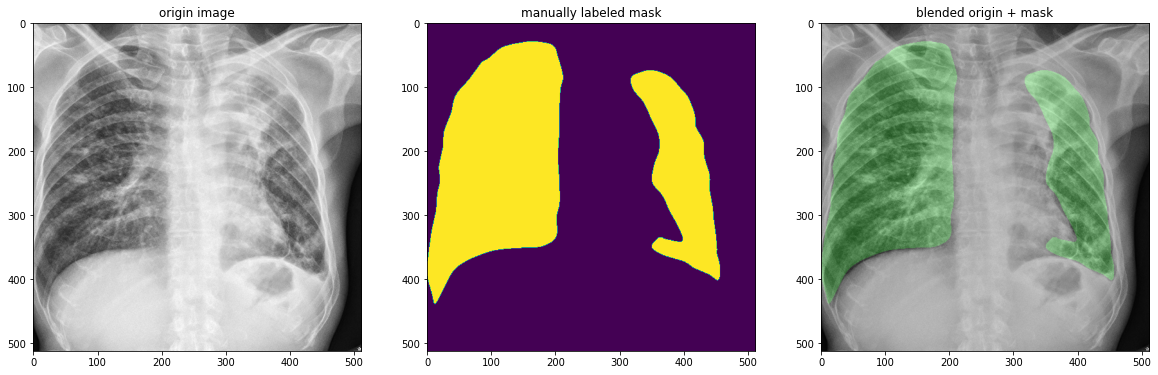

In [ ]:
idx = 0
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float())

plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("manually labeled mask")
plt.imshow(np.array(pil_mask))

plt.subplot(1, 3, 3)
plt.title("blended origin + mask")
plt.imshow(np.array(blend(origin, mask)));

plt.savefig(images_folder / "data-example.png", bbox_inches='tight')

**Train** 

In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)
unet = unet.to(device)
# optimizer = torch.optim.SGD(unet.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [ ]:
print(unet)

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp '/content/gdrive/My Drive/EECS545/unet-2v.pt' '/content/models'
!cp '/content/gdrive/My Drive/EECS545/unet-6v.pt' '/content/models'

Mounted at /content/gdrive


In [14]:
train_log_filename = "train-log.txt"
epochs = 30
best_val_loss = np.inf
model_name = "unet-6v.pt"

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()
    
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)
        
        origins = origins.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * num
        print(".", end="")
        
    train_loss = train_loss / len(datasets['train'])
    print()
    
    
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    print()
    
    
    end_t = time.time()
    spended_t = end_t - start_t
    
    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), models_folder / model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        print()

train phase


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


...............................................................................................................................
validation phase
...............
epoch: 1/30, time: 176.24976587295532, train loss: 0.0953449267938203, 
val loss: 0.0813609476675067, val jaccard: 0.8958200582286768, val dice: 0.9437687480658815
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 2/30, time: 175.95212197303772, train loss: 0.07826701669471538, 
val loss: 0.2339037113022386, val jaccard: 0.6887477082118654, val dice: 0.7993194356299284

train phase
...............................................................................................................................
validation phase
...............
epoch: 3/30, time: 176.05386352539062, train loss: 0.0684046465977143, 
val loss: 0.09349256479426434, val jaccard: 0.8668940015006483, val dice: 0.92

epochs: 30, overall time: 87.0m, mean epoch time: 175.5757523059845s


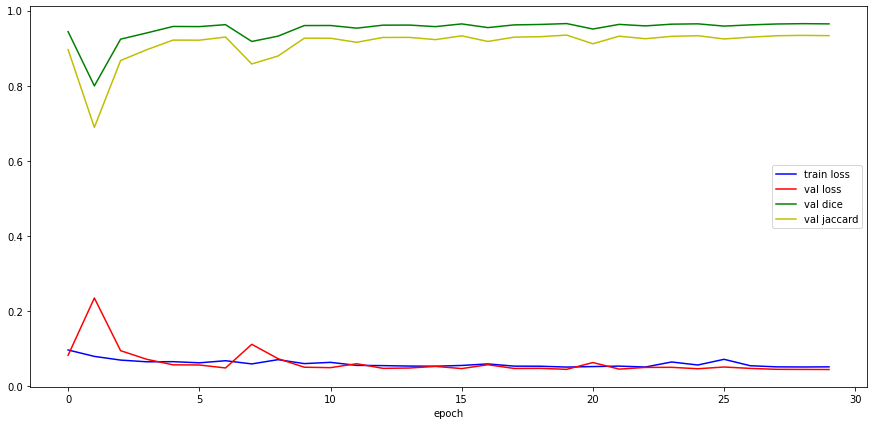

In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

**Evaluate**

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


....................................
avg test loss: 0.05338600795742468
avg test jaccard: 0.9244317746331506
avg test dice: 0.9599283117774531


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


.........
red area - predict
green area - ground truth
yellow area - intersection


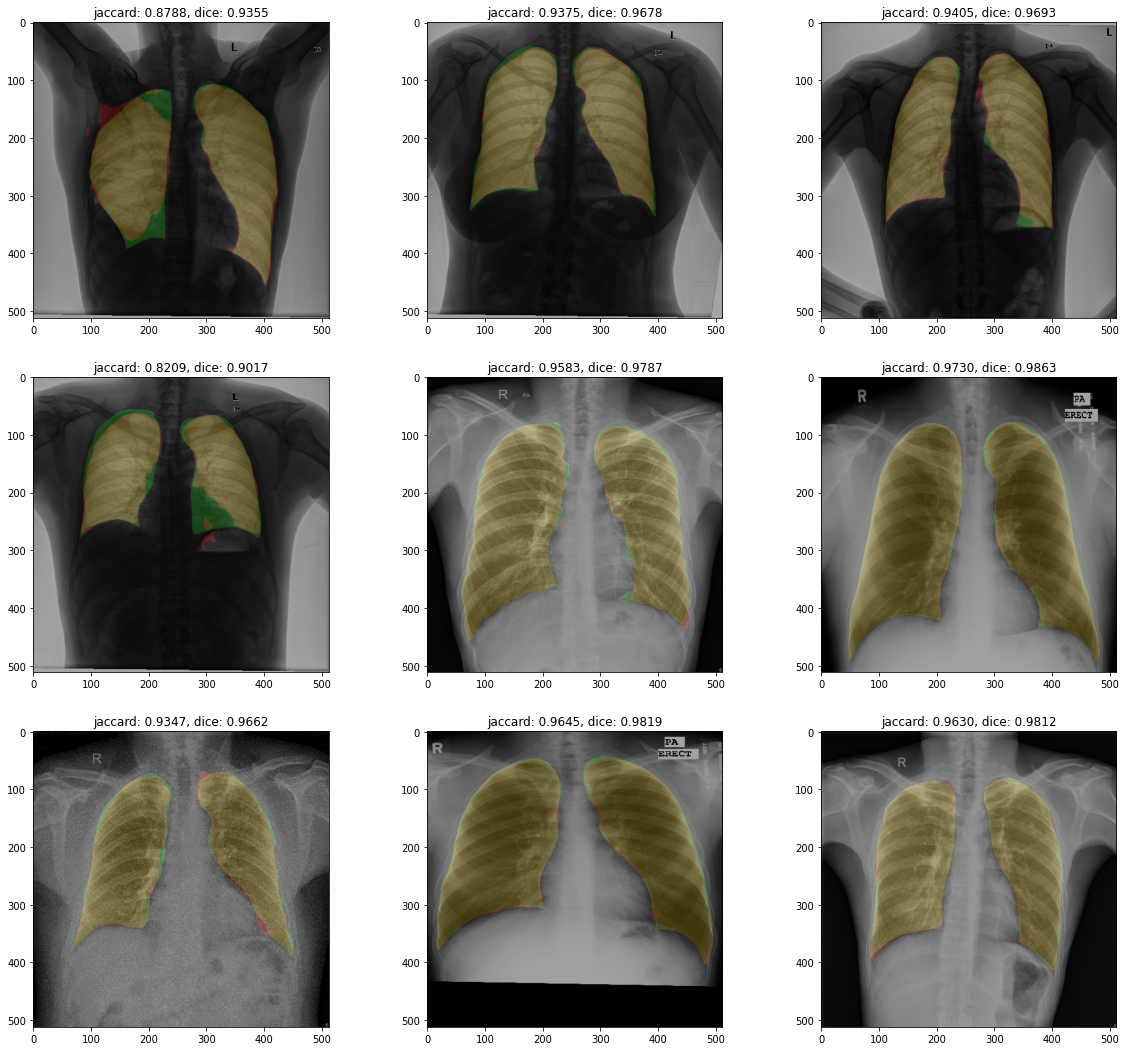

In [ ]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase], 
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin1 = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin1, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")
            
plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()         
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")

In [ ]:
with torch.no_grad():
  out = unet(origin)
  softmax = torch.nn.functional.log_softmax(out, dim=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
out1[0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

**Test on our dataset**

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp '/content/gdrive/My Drive/EECS545/Balanced_Dataset.zip' '/content'
!unzip 'Balanced_Dataset.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Balanced_Dataset/COVID/COVID-3264.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-3264.png  
  inflating: /content/Balanced_Dataset/COVID/COVID-1473.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-1473.png  
  inflating: /content/Balanced_Dataset/COVID/COVID-2393.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-2393.png  
  inflating: /content/Balanced_Dataset/COVID/COVID-1842.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-1842.png  
  inflating: /content/Balanced_Dataset/COVID/COVID-719.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-719.png  
  inflating: /content/Balanced_Dataset/COVID/COVID-1856.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-1856.png  
  inflating: /content/Balanced_Dataset/COVID/COVID-3099.png  
  inflating: /content/__MACOSX/Balanced_Dataset/COVID/._COVID-3099.png  
  infl

In [16]:
unet = PretrainedUNet(1, 2, True, "bilinear")
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [36]:
import os
#os.mkdir('/content/Mask_output/')
output_directory_path='/content/Mask_output/COVID'
os.mkdir(output_directory_path)

In [37]:
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
img_list = os.listdir('/content/Balanced_Dataset/COVID/')
for i in tqdm(range(len(img_list))):
    img_name = img_list[i] 
    img_path = '/content/Balanced_Dataset/COVID/'+ img_list[i] 
      #read image from image path
    origin_name, mask_name = img_name,None
    origin = Image.open(img_path).convert("P")
        
   
    origin, mask = val_test_transforms ((origin, origin))
            
    origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    origin = origin.to(device)
    
    
    with torch.no_grad():
      out = unet(origin.unsqueeze(0))
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
    out=out[0].to("cpu")
    origin1 = origin[0].to("cpu")
    
    image = cv2.imread( img_path,-1)
    image = cv2.resize(image, (512,512) ,interpolation = cv2.INTER_AREA)
    output = cv2.bitwise_and(image, (np.array(out.detach().cpu().numpy())* 255.).astype(np.uint8))  
    #print(mask_img.shape)
    #print(image.shape)
    
   
    #cv2.imwrite(result_dir+"\\COVID_"+str(i)+".png",output)
    cv2.imwrite(output_directory_path+'/'+img_name,output)

  0%|          | 0/3616 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 3616/3616 [03:16<00:00, 18.37it/s]


In [38]:
!zip -r /content/Mask_output.zip /content/Mask_output

Streaming output truncated to the last 5000 lines.
  adding: content/Mask_output/Normal/Normal-2742.png (deflated 3%)
  adding: content/Mask_output/Normal/Normal-2811.png (deflated 1%)
  adding: content/Mask_output/Normal/Normal-1520.png (deflated 2%)
  adding: content/Mask_output/Normal/Normal-2814.png (deflated 3%)
  adding: content/Mask_output/Normal/Normal-2465.png (deflated 2%)
  adding: content/Mask_output/Normal/Normal-2026.png (deflated 2%)
  adding: content/Mask_output/Normal/Normal-697.png (deflated 2%)
  adding: content/Mask_output/Normal/Normal-2757.png (deflated 2%)
  adding: content/Mask_output/Normal/Normal-921.png (deflated 1%)
  adding: content/Mask_output/Normal/Normal-3034.png (deflated 4%)
  adding: content/Mask_output/Normal/Normal-3411.png (deflated 2%)
  adding: content/Mask_output/Normal/Normal-1222.png (deflated 1%)
  adding: content/Mask_output/Normal/Normal-684.png (deflated 1%)
  adding: content/Mask_output/Normal/Normal-886.png (deflated 2%)
  adding: conte

In [39]:
image = cv2.imread( img_path,-1)
image = cv2.resize(image, (512,512) ,interpolation = cv2.INTER_AREA)
output = cv2.bitwise_and(image, (np.array(out.detach().cpu().numpy())* 255.).astype(np.uint8))

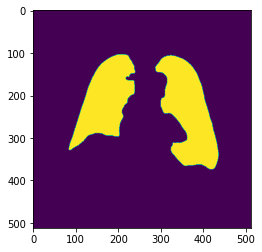

In [43]:
plt.imshow(np.array(out.to("cpu")))

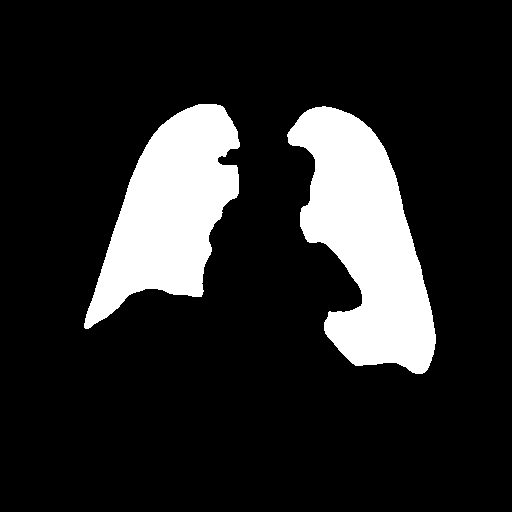

In [40]:
from google.colab.patches import cv2_imshow
cv2_imshow((np.array(out.detach().cpu().numpy())* 255.).astype(np.uint8))

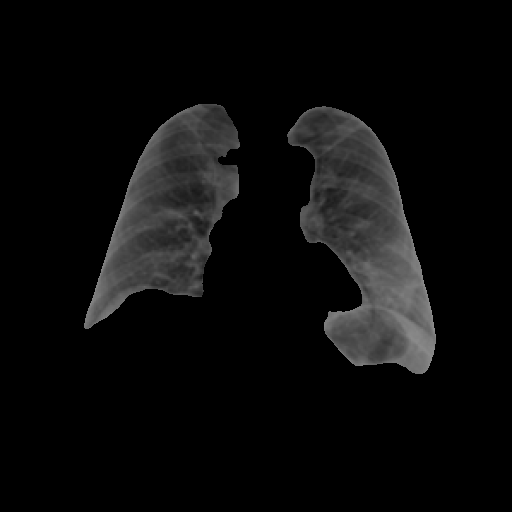

In [41]:
from google.colab.patches import cv2_imshow
cv2_imshow(output)

In [42]:
img_path

'/content/Balanced_Dataset/COVID/COVID-2777.png'